In [2]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import heapq
import pandas as pd

C:\Users\assas\AppData\Local\Temp\ipykernel_16040\846880267.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
img = cv.imread('../../../data/tibia_fibula_fracture/fracture/0.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dns)
thresh = cv.threshold(cl1,120,255,cv.THRESH_BINARY)[1]
kernel = np.ones((15,1), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
kernel = np.ones((17,3), np.uint8)
morph = cv.morphologyEx(morph, cv.MORPH_CLOSE, kernel)

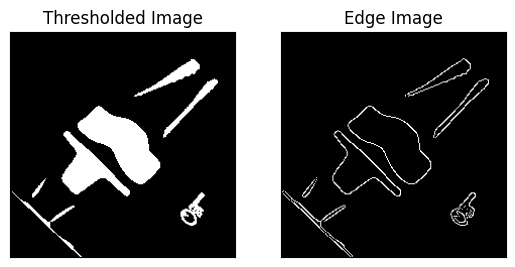

In [10]:
edges = cv.Canny(thresh, 175, 200, None, 3)
plt.subplot(121),plt.imshow(thresh,cmap = 'gray')
plt.title('Thresholded Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
import heapq

class Node(object):
    def __init__(self, val: tuple):
        self.val = val

    def __repr__(self):
        return f'Node value: {self.val}'

    def __lt__(self, other):
        return self.val[0] < other.val[0]
    def return_val(self):
        return self.val

In [5]:
import heapq
result = img.copy()
linesP = cv.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)
heap = []
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        heapq.heappush(heap, Node((np.linalg.norm(np.array((l[0], l[1])) - np.array((l[2], l[3]))) / edges.shape[0], l)))

In [6]:
for line in heapq.nlargest(10, heap):
    _, l = line.return_val()
    cv.line(result, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

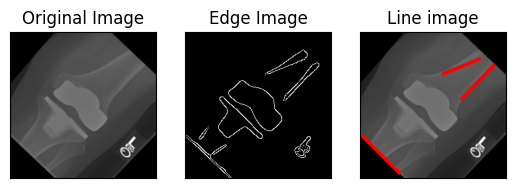

In [7]:
cdst = cv.cvtColor(result, cv.COLOR_BGR2RGB)
plt.subplot(1, 3, 1),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2),plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3),plt.imshow(cdst)
plt.title('Line image'), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
def image_processing(image_dir):
    img = cv.imread(image_dir)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(dns)
    threshold = cv.threshold(cl1,120,255,cv.THRESH_BINARY)[1]
    return cv.Canny(threshold, 175, 200, None, 3)

In [9]:
class Node(object):
    def __init__(self, val: tuple):
        self.val = val

    def __repr__(self):
        return f'Node value: {self.val}'

    def __lt__(self, other):
        return self.val[0] < other.val[0]
    def return_val(self):
        return self.val
    
def get_features(canny_edges, linesP):
    heap = []
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            heapq.heappush(heap, Node((np.linalg.norm(np.array((l[0], l[1])) - np.array((l[2], l[3]))) / canny_edges.shape[0], l)))
        perimeter = cv.countNonZero(canny_edges)/canny_edges.shape[0]
        nm_lns = len(linesP)
        length_pxl = []
        slopes = []
        for line in heapq.nlargest(10, heap):
            length, l = line.return_val()
            length_pxl.append(length)
            x1, y1, x2, y2 = (l[0], l[1], l[2], l[3])
            if x2 - x1 == 0:  # Check if the line is vertical
                slope = np.inf  # Use np.inf to represent infinity
            else:
                slope = (-(y2 - y1)) / (x2 - x1)  # Negate the y-coordinates
            slopes.append(slope)

        max_acute_angle = 0
        min_acute_angle = np.pi / 2  # Initialize to 90 degrees
        for i in range(len(slopes)):
            for j in range(i+1, len(slopes)):
                if np.isinf(slopes[i]) or np.isinf(slopes[j]):
                    angle = np.pi / 2  # The angle between a vertical line and any other line is 90 degrees
                else:
                    angle = np.arccos((slopes[i]*slopes[j] + 1) / np.sqrt((1+slopes[i]**2)*(1+slopes[j]**2)))
                if angle > np.pi/2:  # Only consider acute angles
                    angle = np.pi - angle
                max_acute_angle = max(max_acute_angle, angle)
                min_acute_angle = min(min_acute_angle, angle)

        max_acute_angle = np.degrees(max_acute_angle)  # Convert to degrees
        min_acute_angle = np.degrees(min_acute_angle)

        return [perimeter, nm_lns, np.mean(length_pxl), np.std(length_pxl), np.mean(np.ma.masked_invalid(slopes)), np.std(np.ma.masked_invalid(slopes)), max_acute_angle, min_acute_angle]
    else:
        return None
    

In [10]:
def canny_hough_features(input_dir, output_dir, mode, fracture):
    features = []
    for image_file in os.listdir(input_dir):
        if (image_file.endswith(".png")):
            canny_edges = image_processing(f'{input_dir}/{image_file}')
            linesP = cv.HoughLinesP(canny_edges, 1, np.pi / 180, 50, None, 50, 10)
            feat = get_features(canny_edges, linesP)
            if feat is not None:
                feat.insert(0, fracture)
                feat.insert(0, image_file)
                features.append(feat)
    df = pd.DataFrame(features, columns = ['image_file', 'label', 'perimeter', 'nm_lns', 'mean_length', 'std_length', 'mean_slope', 'std_slope', 'max_acute_angle', 'min_acute_angle'])
    df.to_csv(output_dir, mode=mode, index=False)

In [11]:
fracture_dir = '../../../data/tibia_fibula_fracture/fracture'
nonfracture_dir = '../../../data/tibia_fibula_fracture/normal'
output_dir = './canny_hough_features.csv'
canny_hough_features(fracture_dir, output_dir, mode='w', fracture=1)
canny_hough_features(nonfracture_dir, output_dir, mode='a', fracture=0)